In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from holoviews.plotting.bokeh.styles import alpha
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier


import warnings
warnings.filterwarnings('ignore')


In [2]:
# importing csv
df = pd.read_csv('extractedMimic.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4559 entries, 0 to 4558
Columns: 106 entries, icustay_id to crystalloid_bolus
dtypes: float64(57), int64(39), object(10)
memory usage: 3.7+ MB


In [4]:
df.drop(df[df['age'] < 18].index, inplace=True)

df.describe()

,icustay_id,hadm_id,suspected_infection_time_poe_days,positiveculture_poe,blood_culture_positive,age,is_male,race_white,race_black,race_hispanic,...,glucose_min1,glucose_max1,glucose_mean,rrt,subject_id,hadm_id.1,icustay_id.1,urineoutput,colloid_bolus,crystalloid_bolus
count,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,...,4525.000000,4525.000000,4525.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,508.000000,3361.000000
mean,250637.474863,149922.364874,0.084101,0.136334,0.381339,65.173619,0.565971,0.718771,0.086279,0.032931,...,111.232044,411.037348,177.261026,0.043469,68174.064105,149922.364874,250637.474863,1842.618441,382.694882,645.671229
std,28759.579721,28710.589841,0.290748,0.343180,0.485769,17.622075,0.495683,0.449649,0.280806,0.178475,...,36.773707,14863.345644,2123.773411,0.203932,18470.812604,28710.589841,28759.579721,1535.550605,134.934798,370.024064
min,200075.000000,100003.000000,-0.991076,0.000000,0.000000,18.020900,0.000000,0.000000,0.000000,0.000000,...,12.000000,57.000000,52.444444,0.000000,165.000000,100003.000000,200075.000000,0.000000,150.000000,250.000000
25%,225575.500000,125404.500000,-0.075677,0.000000,0.000000,53.784850,0.000000,0.000000,0.000000,0.000000,...,89.000000,130.000000,112.888889,0.000000,53134.000000,125404.500000,225575.500000,897.500000,250.000000,500.000000
50%,250984.000000,149667.000000,0.034965,0.000000,0.000000,66.591500,1.000000,1.000000,0.000000,0.000000,...,106.000000,166.000000,134.000000,0.000000,68391.000000,149667.000000,250984.000000,1560.000000,500.000000,500.000000
75%,275436.000000,175042.500000,0.157309,0.000000,1.000000,79.540400,1.000000,1.000000,0.000000,0.000000,...,127.000000,217.000000,165.000000,0.000000,83771.500000,175042.500000,275436.000000,2460.000000,500.000000,1000.000000
max,299998.000000,199962.000000,0.995139,1.000000,1.000000,91.400000,1.000000,1.000000,1.000000,1.000000,...,480.000000,999999.000000,142966.857100,1.000000,99982.000000,199962.000000,299998.000000,50515.000000,1000.000000,11000.000000


In [5]:
X = df[['urineoutput', 'lactate_min','bun_mean','sysbp_min', 'metastatic_cancer', 'inr_max', 'age', 'sodium_max', 'aniongap_max', 'creatinine_min', 'spo2_mean']]

y = df['thirtyday_expire_flag']

In [6]:
X.fillna(X.median(), inplace=True)

In [7]:
X.isnull().sum()

urineoutput          0
lactate_min          0
bun_mean             0
sysbp_min            0
metastatic_cancer    0
inr_max              0
age                  0
sodium_max           0
aniongap_max         0
creatinine_min       0
spo2_mean            0
dtype: int64

In [8]:
X.shape

(4555, 11)

In [9]:
# Step 3: Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes of the resulting datasets
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (3644, 11)
Testing set shape: (911, 11)


In [10]:
# Step 1: Train the XGBoost model with hyperparameter tuning
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss', 
    booster='gbtree', 
    objective='binary:logistic', 
    n_estimators=90,      # Increased number of trees for better learning
    max_depth=6,           # Control the depth of trees
    learning_rate=0.05,    # Reduced learning rate
    subsample=0.8,         # Control overfitting by using 80% of data for each tree
    colsample_bytree=0.8,  # Feature subsampling
    gamma=0.05,
)
xgb_model.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0.05, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=90, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, ...)

In [11]:
# Step 2: Make predictions on the test set
y_pred = xgb_model.predict(X_test)  # Predicted labels (0 or 1)
y_probs = xgb_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1


In [12]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Assuming y_test, y_pred, and y_probs are already defined
# y_test: True class labels
# y_pred: Predicted class labels
# y_probs: Predicted probabilities (for AUC)

# Step 3: Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)  # Accuracy
auc = roc_auc_score(y_test, y_probs)  # AUC
precision = precision_score(y_test, y_pred, average='binary')  # Precision (binary classification)
recall = recall_score(y_test, y_pred, average='binary')  # Recall (binary classification)
conf_matrix = confusion_matrix(y_test, y_pred)  # Confusion matrix
class_report = classification_report(y_test, y_pred)  # Classification report

# Print evaluation metrics
print(f"Model Accuracy: {accuracy * 100:.5f}%")
print(f"Model Precision: {precision * 100:.5f}%")
print(f"Model Recall: {recall * 100:.5f}%")
print(f"Model AUC: {auc * 100:.5f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Model Accuracy: 85.51043%
Model Precision: 79.76190%
Model Recall: 36.81319%
Model AUC: 84.74804%
Confusion Matrix:
[[712  17]
 [115  67]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       729
           1       0.80      0.37      0.50       182

    accuracy                           0.86       911
   macro avg       0.83      0.67      0.71       911
weighted avg       0.85      0.86      0.83       911



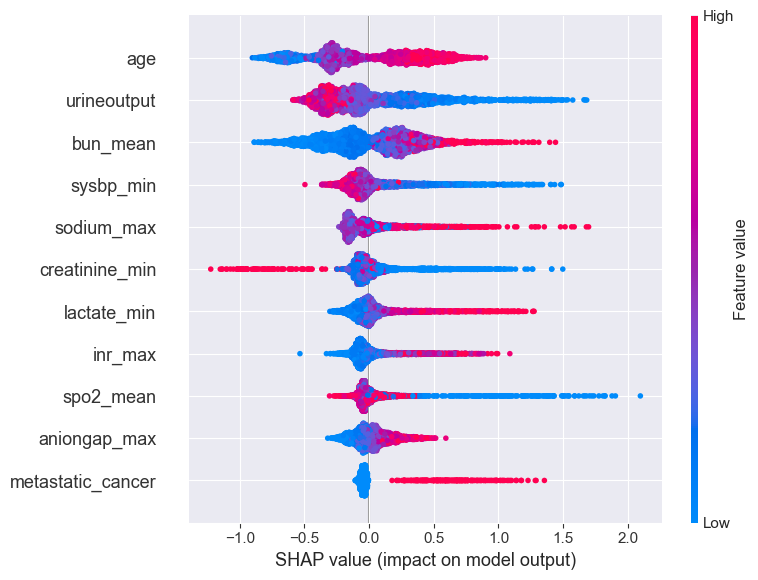

In [13]:
import shap
import matplotlib.pyplot as plt

# Initialize the SHAP explainer
explainer = shap.Explainer(xgb_model, X_train)

# Calculate SHAP values
shap_values = explainer(X_train)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train)


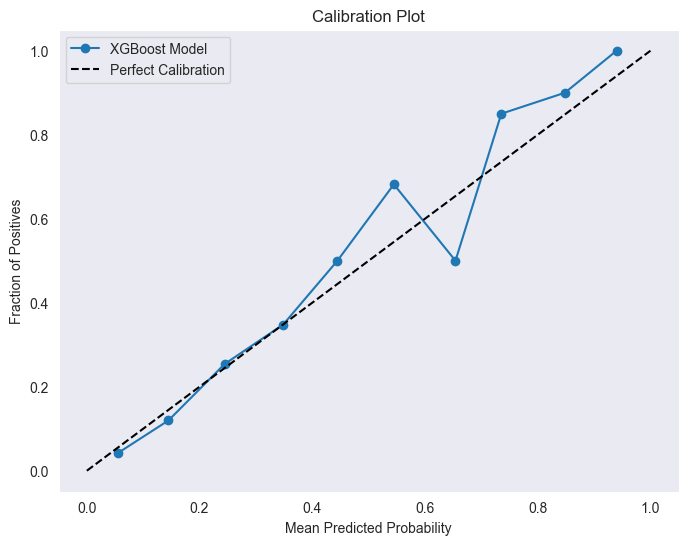

In [15]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Predict probabilities
y_prob = xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Calculate the calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy='uniform')

# Plot the calibration curve
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label="XGBoost Model")
plt.plot([0, 1], [0, 1], "k--", label="Perfect Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Plot")
plt.legend(loc="best")
plt.grid()
plt.show()


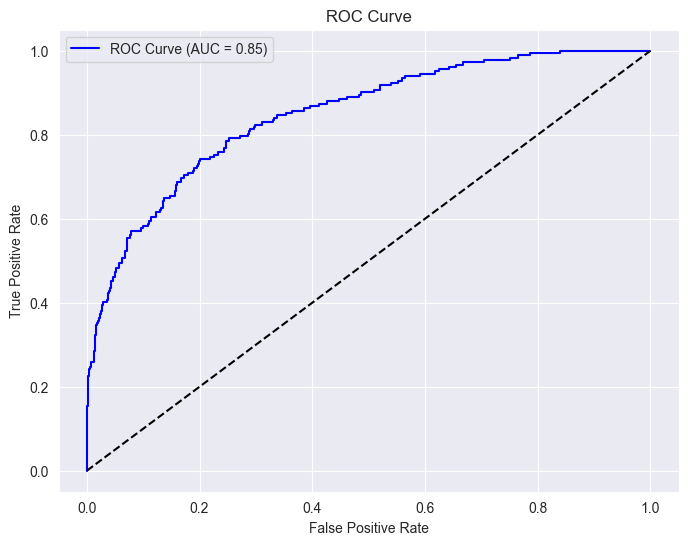

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate ROC curve points and AUC score
y_probs = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

# Plot and save the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.savefig('roc_curve.png')
plt.show()


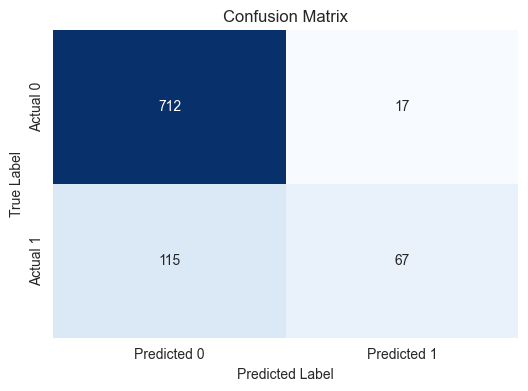

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot and save the confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix.png')
plt.show()


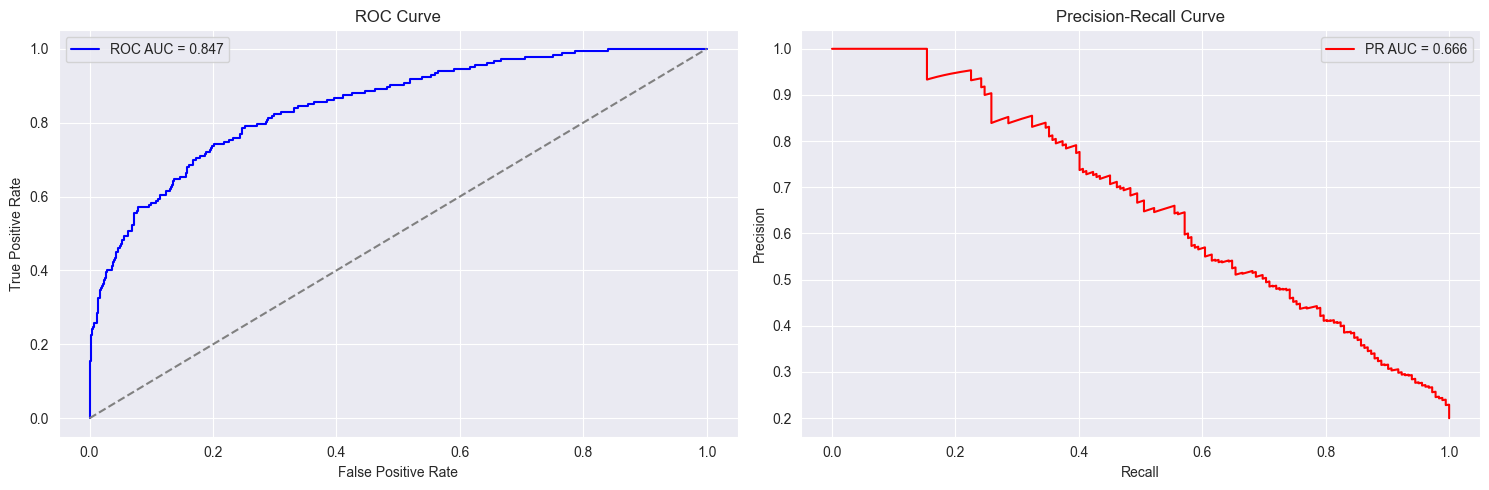

In [13]:
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix, 
                           classification_report, roc_curve, precision_recall_curve, 
                           average_precision_score, auc)
import matplotlib.pyplot as plt

# Step 3: Calculate various metrics
def calculate_metrics(y_true, y_pred, y_probs):
    metrics = {}
    
    # Basic metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['roc_auc'] = roc_auc_score(y_true, y_probs)
    
    # ROC Curve data
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    metrics['roc_curve'] = {'fpr': fpr, 'tpr': tpr}
    
    # Precision-Recall curve data
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    metrics['pr_curve'] = {'precision': precision, 'recall': recall}
    metrics['average_precision'] = average_precision_score(y_true, y_probs)
    
    # Calculate PR AUC
    metrics['pr_auc'] = auc(recall, precision)
    
    return metrics

# Calculate all metrics
metrics = calculate_metrics(y_test, y_pred, y_probs)

# Step 4: Plot ROC and PR curves
def plot_curves(metrics):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot ROC curve
    ax1.plot(metrics['roc_curve']['fpr'], 
             metrics['roc_curve']['tpr'], 
             color='blue', 
             label=f"ROC AUC = {metrics['roc_auc']:.3f}")
    ax1.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    ax1.legend()
    ax1.grid(True)
    
    # Plot PR curve
    ax2.plot(metrics['pr_curve']['recall'], 
             metrics['pr_curve']['precision'], 
             color='red', 
             label=f"PR AUC = {metrics['pr_auc']:.3f}")
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot the curves
plot_curves(metrics)

In [39]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters grid to search
param_grid = {
    'n_estimators': [90, 100, 150],            # Number of trees
    'max_depth': [3, 6, 10],                    # Depth of trees
    'learning_rate': [0.01, 0.05, 0.1],         # Learning rate
    'subsample': [0.7, 0.8, 0.9],               # Subsample ratio
    'colsample_bytree': [0.7, 0.8, 0.9],        # Feature subsampling ratio
    'gamma': [0, 0.1, 0.5],                    # Minimum loss reduction
}

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    booster='gbtree',
    objective='binary:logistic'
)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best AUC: {grid_search.best_score_ * 100:.5f}%")

# Use the best estimator to predict and evaluate performance
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_probs = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_probs)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print evaluation metrics
print(f"Model Accuracy: {accuracy * 100:.5f}%")
print(f"Model AUC: {auc * 100:.5f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters: {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}
Best AUC: 80.99741%
Model Accuracy: 85.72997%
Model AUC: 83.61070%
Confusion Matrix:
[[715  14]
 [116  66]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       729
           1       0.82      0.36      0.50       182

    accuracy                           0.86       911
   macro avg       0.84      0.67      0.71       911
weighted avg       0.85      0.86      0.83       911



In [21]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from xgboost import XGBClassifier
import numpy as np

# Define the XGBoost model with initial parameters
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Parameter grid to improve model complexity and generalization
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Use GridSearchCV to find the best parameters with StratifiedKFold cross-validation
stratified_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=stratified_cv, scoring='roc_auc')
grid_search.fit(X, y)

# Best model with tuned parameters
best_xgb_model = grid_search.best_estimator_

# Run cross-validation with the tuned model and StratifiedKFold
auc_scores = cross_val_score(best_xgb_model, X, y, cv=stratified_cv, scoring='roc_auc')

# Print AUC for each fold
for i, auc in enumerate(auc_scores):
    print(f"Fold {i + 1}: AUC = {auc:.4f}")

# Summary statistics for AUC scores
min_auc = np.min(auc_scores)
max_auc = np.max(auc_scores)
avg_auc = np.mean(auc_scores)

print(f"\nMinimum AUC: {min_auc:.4f}")
print(f"Maximum AUC: {max_auc:.4f}")
print(f"Average AUC: {avg_auc:.4f}")


Fold 1: AUC = 0.8523
Fold 2: AUC = 0.7671
Fold 3: AUC = 0.7997
Fold 4: AUC = 0.7602
Fold 5: AUC = 0.8222
Fold 6: AUC = 0.8518
Fold 7: AUC = 0.8342
Fold 8: AUC = 0.8069
Fold 9: AUC = 0.8471
Fold 10: AUC = 0.8027

Minimum AUC: 0.7602
Maximum AUC: 0.8523
Average AUC: 0.8144


In [22]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import xgboost as xgb

# Define the hyperparameters grid for tuning
param_grid = {
    'n_estimators': [90, 100, 150],             # Number of trees
    'max_depth': [3, 6, 10],                    # Depth of trees
    'learning_rate': [0.01, 0.05, 0.1],         # Learning rate
    'subsample': [0.7, 0.8, 0.9],               # Subsample ratio
    'colsample_bytree': [0.7, 0.8, 0.9],        # Feature subsampling ratio
    'gamma': [0, 0.1, 0.5],                     # Minimum loss reduction
}

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    booster='gbtree',
    objective='binary:logistic'
)

# Stratified K-Fold for balanced cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV with Stratified K-Fold
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='roc_auc', cv=stratified_cv, n_jobs=-1, verbose=1)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best AUC: {grid_search.best_score_ * 100:.5f}%")

# Use the best estimator to make predictions and evaluate performance
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_probs = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model's performance on the test set
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_probs)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print evaluation metrics
print(f"Model Accuracy: {accuracy * 100:.5f}%")
print(f"Model AUC: {auc * 100:.5f}%")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Best AUC: 81.12571%
Model Accuracy: 85.29089%
Model AUC: 83.96418%
Confusion Matrix:
[[710  19]
 [115  67]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       729
           1       0.78      0.37      0.50       182

    accuracy                           0.85       911
   macro avg       0.82      0.67      0.71       911
weighted avg       0.84      0.85      0.83       911



In [11]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import xgboost as xgb
import numpy as np

# Define the hyperparameters grid for tuning
param_grid = {
    'n_estimators': [90, 150],             # Number of trees
    'max_depth': [3, 6],                    # Depth of trees
    'learning_rate': [0.01, 0.05],         # Learning rate
    'subsample': [0.7, 0.8],               # Subsample ratio
    'colsample_bytree': [0.7, 0.8],        # Feature subsampling ratio
    'gamma': [ 0.1, 0.5],                     # Minimum loss reduction
}

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    booster='gbtree',
    objective='binary:logistic'
)

# Stratified K-Fold for balanced cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV with Stratified K-Fold
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='roc_auc', cv=stratified_cv, n_jobs=-1, verbose=1)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Best estimator and best AUC from GridSearchCV
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best AUC from GridSearchCV: {grid_search.best_score_ * 100:.5f}%")

# Perform cross-validation on the best model to get AUC scores for each fold
auc_scores = cross_val_score(best_model, X_train, y_train, cv=stratified_cv, scoring='roc_auc')

# Print min, max, and average AUC from cross-validation
min_auc = np.min(auc_scores)
max_auc = np.max(auc_scores)
avg_auc = np.mean(auc_scores)

print(f"\nMinimum AUC: {min_auc * 100:.5f}%")
print(f"Maximum AUC: {max_auc * 100:.5f}%")
print(f"Average AUC: {avg_auc * 100:.5f}%")

# Use the best estimator to predict and evaluate performance on test data
y_pred = best_model.predict(X_test)
y_probs = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model's performance on the test set
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_probs)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print evaluation metrics on the test set
print(f"\nModel Accuracy on Test Set: {accuracy * 100:.5f}%")
print(f"Model AUC on Test Set: {auc * 100:.5f}%")
print("Confusion Matrix on Test Set:")
print(conf_matrix)
print("Classification Report on Test Set:")
print(class_report)


Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.7}
Best AUC from GridSearchCV: 80.90343%

Minimum AUC: 77.98786%
Maximum AUC: 82.51194%
Average AUC: 80.90343%

Model Accuracy on Test Set: 86.05928%
Model AUC on Test Set: 84.00187%
Confusion Matrix on Test Set:
[[715  14]
 [113  69]]
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       729
           1       0.83      0.38      0.52       182

    accuracy                           0.86       911
   macro avg       0.85      0.68      0.72       911
weighted avg       0.86      0.86      0.84       911



In [ ]:
auc_scores

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Best AUC from GridSearchCV: 81.12571%


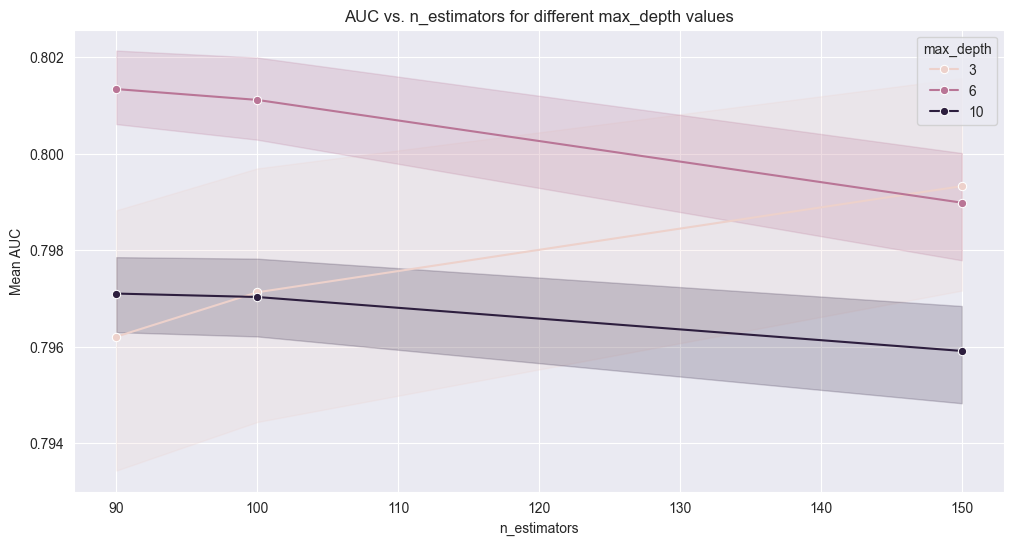

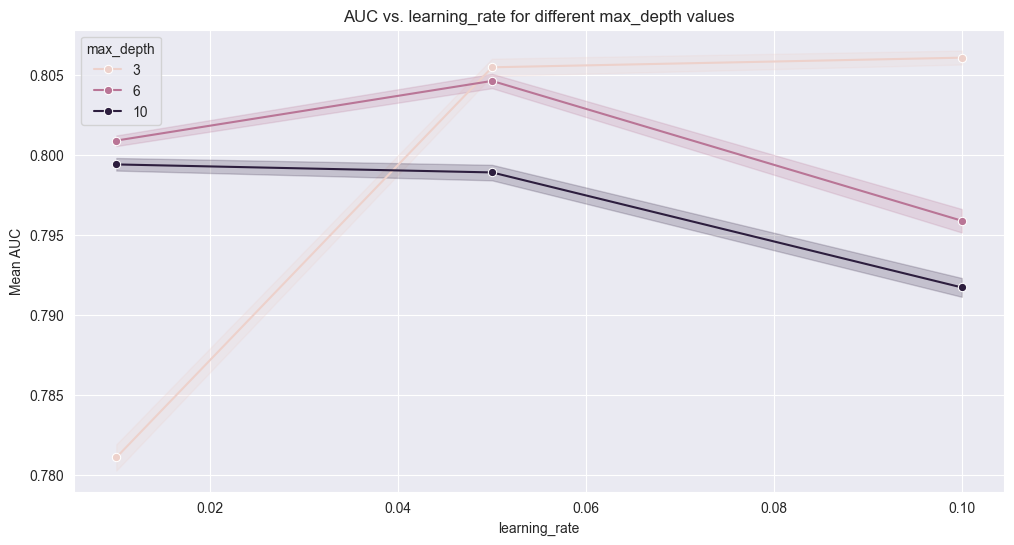


Model Accuracy on Test Set: 85.29089%
Model AUC on Test Set: 83.96418%
Confusion Matrix on Test Set:
[[710  19]
 [115  67]]
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       729
           1       0.78      0.37      0.50       182

    accuracy                           0.85       911
   macro avg       0.82      0.67      0.71       911
weighted avg       0.84      0.85      0.83       911



In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import xgboost as xgb
import numpy as np

# Define the hyperparameters grid for tuning
param_grid = {
    'n_estimators': [90, 100, 150],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.5],
}

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    booster='gbtree',
    objective='binary:logistic'
)

# Stratified K-Fold for balanced cross-validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up GridSearchCV with Stratified K-Fold
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='roc_auc', cv=stratified_cv, n_jobs=-1, verbose=1)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Best estimator and best AUC from GridSearchCV
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best AUC from GridSearchCV: {grid_search.best_score_ * 100:.5f}%")

# Extract results into a DataFrame for visualization
results_df = pd.DataFrame(grid_search.cv_results_)

# Plot AUC scores for combinations of max_depth and n_estimators
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x="param_n_estimators", y="mean_test_score", hue="param_max_depth", marker="o")
plt.title("AUC vs. n_estimators for different max_depth values")
plt.xlabel("n_estimators")
plt.ylabel("Mean AUC")
plt.legend(title="max_depth")
plt.show()

# Plot AUC scores for combinations of learning_rate and max_depth
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x="param_learning_rate", y="mean_test_score", hue="param_max_depth", marker="o")
plt.title("AUC vs. learning_rate for different max_depth values")
plt.xlabel("learning_rate")
plt.ylabel("Mean AUC")
plt.legend(title="max_depth")
plt.show()

# Use the best estimator to predict and evaluate performance on test data
y_pred = best_model.predict(X_test)
y_probs = best_model.predict_proba(X_test)[:, 1]

# Evaluate the model's performance on the test set
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_probs)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print evaluation metrics on the test set
print(f"\nModel Accuracy on Test Set: {accuracy * 100:.5f}%")
print(f"Model AUC on Test Set: {auc * 100:.5f}%")
print("Confusion Matrix on Test Set:")
print(conf_matrix)
print("Classification Report on Test Set:")
print(class_report)


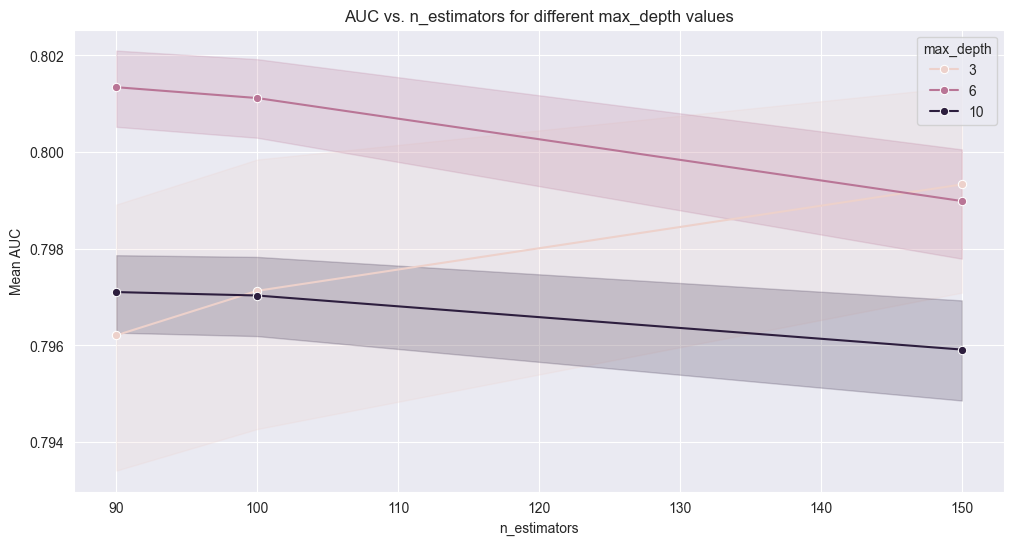

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `results_df` contains GridSearchCV results and relevant columns
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x="param_n_estimators", y="mean_test_score", 
             hue="param_max_depth", marker="o")
plt.title("AUC vs. n_estimators for different max_depth values")
plt.xlabel("n_estimators")
plt.ylabel("Mean AUC")
plt.legend(title="max_depth")
plt.savefig('auc_n_estimators_max_depth.png')
plt.show()


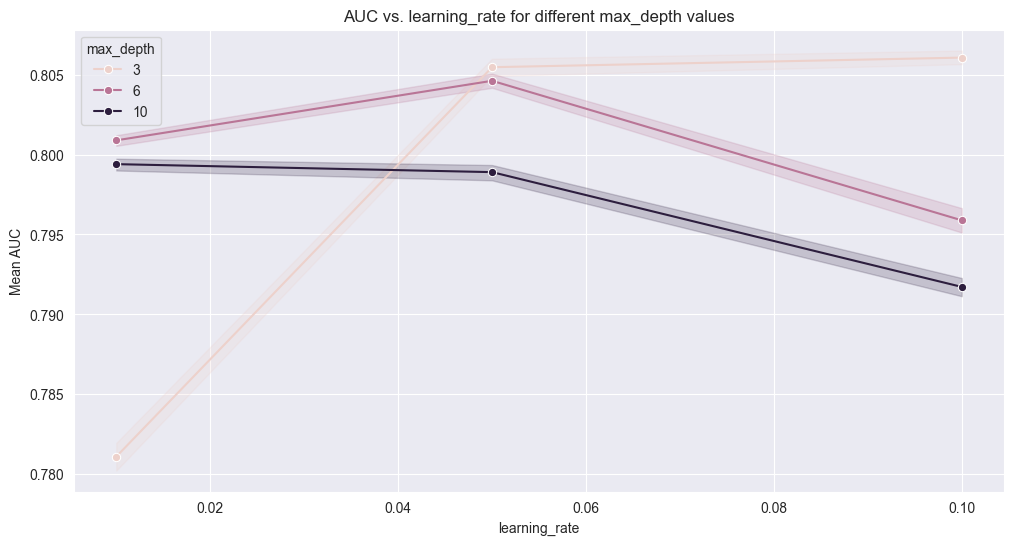

In [27]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x="param_learning_rate", y="mean_test_score", 
             hue="param_max_depth", marker="o")
plt.title("AUC vs. learning_rate for different max_depth values")
plt.xlabel("learning_rate")
plt.ylabel("Mean AUC")
plt.legend(title="max_depth")
plt.savefig('auc_learning_rate_max_depth.png')
plt.show()


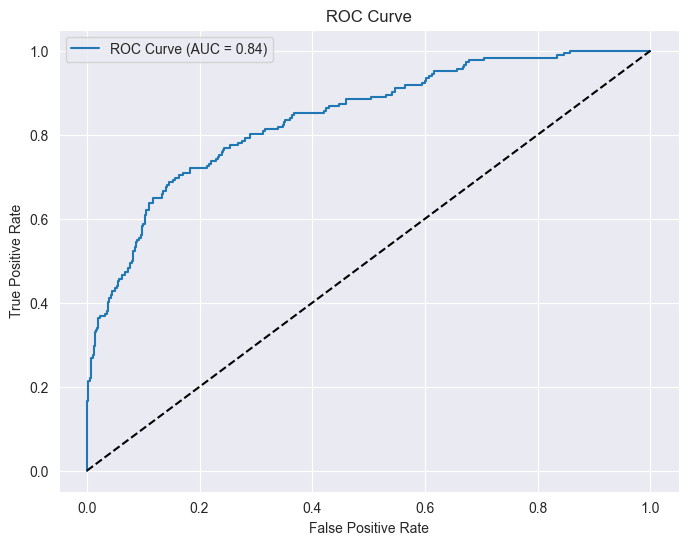

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score

# Generate ROC curve
y_probs = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_probs)
auc = roc_auc_score(y_test, y_probs)

# Plot and save ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.savefig('roc_curve.png')
plt.show()


<Figure size 800x600 with 0 Axes>

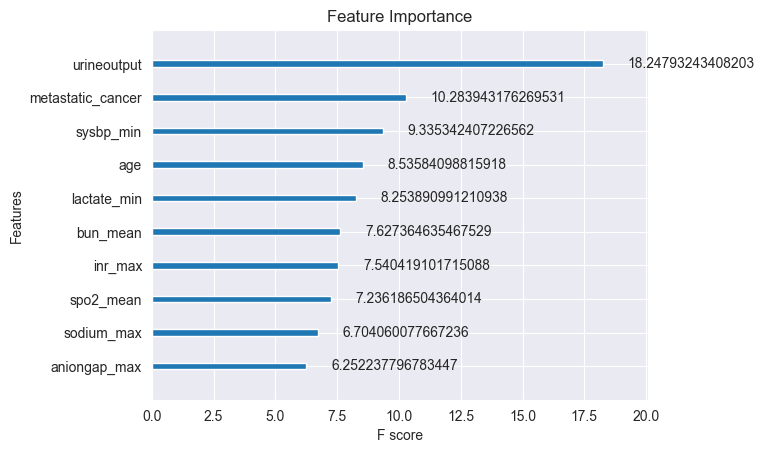

In [29]:
import xgboost as xgb

# Plot and save feature importance
plt.figure(figsize=(8, 6))
xgb.plot_importance(best_model, max_num_features=10, importance_type='gain')
plt.title('Feature Importance')
plt.savefig('feature_importance.png')
plt.show()
